In [1]:
import requests
import base64
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np

In [27]:
def sketch_thick(img_path):
    target_url = "http://localhost:8895/sketch_thick"

    dict = {}
    dict['path'] = img_path

    response = requests.post(target_url, data=json.dumps(dict))

    data = json.loads(response.text)
    src = data['output_path']

    img = cv2.imread(src)

    return img, src
def sketch_thin(img_path):
    target_url = "http://localhost:8895/sketch_thin"

    dict = {}
    dict['path'] = img_path

    response = requests.post(target_url, data=json.dumps(dict))

    data = json.loads(response.text)
    src = data['output_path']

    img = cv2.imread(src)

    return img, src

In [3]:
def img_to_imgpath(img):
    path = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_post.png'
    cv2.imwrite(path, img)
    
    return path

In [15]:
def cartoonize(img):
    target_url = "http://localhost:8894/predict"

    _, img_encoded = cv2.imencode('.jpg', img, params=[cv2.IMWRITE_JPEG_QUALITY, 50])
    img = cv2.imdecode(img_encoded, 1)
    # send http request with image and receive response
    jpg_as_text = base64.b64encode(img_encoded).decode()
    dict = {}
    dict['image'] = jpg_as_text

    response = requests.post(target_url, data=json.dumps(dict))

    lists = json.loads(response.text)
    jpg_original = base64.b64decode(lists[0]['image'])
    jpg_as_np = np.frombuffer(jpg_original, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)

    path = img_to_imgpath(img)
    
    return img, path

In [16]:
def remove_bg(img_path):
    target_url = "http://localhost:8895/remove_bg"

    dict = {}
    dict['img_path'] = img_path

    response = requests.post(target_url, data=json.dumps(dict))

    data = json.loads(response.text)
#     print(data)

    img = cv2.imread(data)
    return img, data

In [17]:
pip install cartooner


Looking in indexes: http://ftp.daumkakao.com/pypi/simple
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [42]:
from cartooner import cartoonize as car

import glob
from PIL import Image
test_paths = glob.glob('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/train_data/im2/*.jpg')
api_list = ['cartoonize', 'sketch_thick']
save_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_combination/'

# 패쓰 = 'train_data/gt_nobg/806500H01_1_21-TH-06-050_00374.png'
dim = (640, 640)
img1 = cv2.imread(test_paths[0])
resized_img = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
# print(resized_img)
img2, path2 = cartoonize(resized_img)

img1 = car(resized_img)
img1, path2 = cartoonize(img1)

cv2.imwrite('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/tt.png', img1)

img1,path = sketch_thick('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/tt.png')
# # img2, path2 = cartoonize(img2)
# img1 = sketch_thick(path2)
# # img2, path2 = cartoonize(img2)
# print(img1)
# Image.fromarray(img2)
Image.fromarray(img1)
# path2
# path2

centroids: [array([ 46.,  78., 107.]), array([ 11.,  37.,  73., 107., 145., 189.]), array([ 77., 163., 211.])]


TypeError: list indices must be integers or slices, not str

In [48]:
import glob
import os

test_paths = glob.glob('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/train_data/im2/*.jpg')
api_list = ['cartoonize', 'sketch_thick']
save_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_combination/'
cnt = 0
for test_img_path in test_paths:
    cnt += 1
    if cnt == 31: break
#     test_img_path = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/train_data/im2/806252H01_1_21-TH-05-958_00864.jpg'    
    image_name = test_img_path.split('/')[-1][:-4]

    img = cv2.imread(test_img_path)
    path = test_img_path

#     img, path = remove_bg(path)
    for idx1 in range(2):
        prefix = 'x360'

        if idx1 == 0:
            h, w = img.shape[:2]
        
            r = 360 / float(h)
            dim = (int(w * r), 360)
        
            resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            img1, path1 = cartoonize(resized_img)
            img1 = cv2.resize(img1, (w, h))
            cv2.imwrite(path1, img1)
            
            prefix += 'c'
        else:
            img1, path1 = sketch_thick(path)
            prefix += 's'

        if(not os.path.exists(save_dir+prefix)):
            os.mkdir(save_dir+prefix)
        cv2.imwrite(save_dir + prefix + '/' + image_name + '.png' , img1)

        for idx2 in range(2):
            prefix2 = prefix
            if idx2 == 0:
                h, w = img1.shape[:2]       
                r = 360 / float(h)
                dim = (int(w * r), 360)

                resized_img = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
                img2, path2 = cartoonize(resized_img)
                img2 = cv2.resize(img2, (w, h))
                cv2.imwrite(path2, img2)
                
                prefix2 += 'c'
            else:
                img2, path2 = sketch_thick(path1)
                prefix2 += 's'
            if(not os.path.exists(save_dir+prefix2)):
                os.mkdir(save_dir+prefix2)
            cv2.imwrite(save_dir + prefix2 + '/' + image_name + '.png' , img2)
            for idx3 in range(2):
                prefix3 = prefix2
                if idx3 == 0:
                    img3, path3 = cartoonize(img2)
                    prefix3 += 'c'
                else:
                    img3, path3 = sketch_thick(path2)
                    prefix3 += 's'

                if(not os.path.exists(save_dir+prefix3)):
                    os.mkdir(save_dir+prefix3)
                cv2.imwrite(save_dir + prefix3 + '/' + image_name + '.png' , img3)
    


# img, path = remove_bg(path)

# img, path = cartoonize(img)

# img, path = sketch_thick(path)


In [7]:
import numpy as np

mask2 = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
ret, mask2 = cv2.threshold(mask2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# kernel = np.ones((5,5), np.uint8)
# mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)
# mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel)

mask2_inv = cv2.bitwise_not(mask2)

# dst_bg = cv2.bitwise_and(dst_img_copy, dst_img_copy, mask=mask_inv)
img_fg = cv2.bitwise_and(img, img, mask=mask2_inv)
img_bg = cv2.bitwise_and(mask, mask, mask=mask2)

result = img_fg + img_bg

plt.imshow(mask2, cmap='gray')
plt.show()
plt.imshow(result)
plt.show()

NameError: name 'mask' is not defined

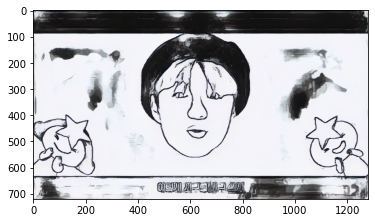

In [4]:
import requests
import json
from matplotlib import pyplot as plt
import cv2

target_url = "http://localhost:8933/sketch"
test_img_path = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/train_data/im2/806229H01_1_21-TH-05-941_00329.jpg'

dict = {}
dict['img_path'] = test_img_path

response = requests.post(target_url, data=json.dumps(dict))

data = json.loads(response.text)
src = data['output_path']

img = cv2.imread(src)


plt.imshow(img)
plt.show()

In [3]:
response.text

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>\n'

In [12]:
import glob
import os
im_path = glob.glob('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2/*.jpg')

for path in im_path:
    img = cv2.imread(path)
    img, _ = remove_bg(path)
#     plt.imshow(img)
#     plt.show()
    
    output_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2_nobg/'
    if(not os.path.exists(output_dir)):
        os.mkdir(output_dir)
    
    dst = os.path.join(output_dir, path.split('/')[-1])
    cv2.imwrite(dst, img)

In [20]:
import glob
import os
im_path = glob.glob('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2_nobg/*.jpg')

for path in im_path:
    img = cv2.imread(path)
    
    h, w = img.shape[:2]
        
    r = 360 / float(h)
    dim = (int(w * r), 360)

    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img1, path1 = cartoonize(resized_img)
    img1 = cv2.resize(img1, (w, h))
    
    
#     img, _ = cartoonize(img)
#     plt.imshow(img1)
#     plt.show()
    
    output_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2_nobg_ct/'
    if(not os.path.exists(output_dir)):
        os.mkdir(output_dir)
    
    dst = os.path.join(output_dir, path.split('/')[-1])
    cv2.imwrite(dst, img1)

In [21]:
import glob
import os
im_path = glob.glob('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2_nobg_ct/*.jpg')

for path in im_path:
    img = cv2.imread(path)
    img, _ = sketch_thick(path)
#     plt.imshow(img)
#     plt.show()
    
    output_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2_nobg_ct_sk/'
    if(not os.path.exists(output_dir)):
        os.mkdir(output_dir)
    
    dst = os.path.join(output_dir, path.split('/')[-1])
    cv2.imwrite(dst, img)

In [22]:
import glob
import os
im_path = glob.glob('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2_nobg_ct_sk/*.jpg')

for path in im_path:
    img = cv2.imread(path)
    img, _ = cartoonize(img)
#     plt.imshow(img)
#     plt.show()
    
    output_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2_nobg_ct_sk_ct/'
    if(not os.path.exists(output_dir)):
        os.mkdir(output_dir)
    
    dst = os.path.join(output_dir, path.split('/')[-1])
    cv2.imwrite(dst, img)

In [52]:
from PIL import Image
import numpy as np
impath = glob.glob('/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/test_data/test_portrait_images/ori_im2_nobg_ct_sk_ct/*.jpg')


for path in impath:
    img = cv2.imread(path)

    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(imgray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    output_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/gt_images/'
    if(not os.path.exists(output_dir)):
        os.mkdir(output_dir)
    
    dst = os.path.join(output_dir, path.split('/')[-1])
    
    cv2.imwrite(dst,mask)
    # plt.imshow(mask,cmap='gray')
    # plt.show()
    # plt.imshow(img)
    # plt.show()

In [ ]:
from PIL import Image
import numpy as np
impath = glob.glob("/home/ubuntu/workspace/kobaco/dataset/data_processing/kobaco_keyframe/**/*.png")

for path in impath:
    img = cv2.imread(path)

    img, path = remove_bg(path)
    
    h, w = img.shape[:2]
    r = 360 / float(h)
    dim = (int(w * r), 360)
    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img, path = cartoonize(resized_img)
    img = cv2.resize(img, (w, h))
    
    img, path = sketch_thick(path)
    
    img, path = cartoonize(img)
    
    output_dir = '/home/ubuntu/workspace/kobaco/sketchy/U-2-Net/processed_im/'
    if(not os.path.exists(output_dir)):
        os.mkdir(output_dir)
    
    dst = os.path.join(output_dir, path.split('/')[-1])
    
    cv2.imwrite(dst, img)
    # plt.imshow(mask,cmap='gray')
    # plt.show()
    # plt.imshow(img)
    # plt.show()